In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    # Adapt multioutput back to fan. pts.
    act = {}
    pred = {}
    dfPred = {}
    for pos in positions:
        act[pos] = y_dev[pos].fanPts
        dfPred[pos] = pd.DataFrame(y_pred[pos], columns = y_dev[pos].columns)
        ppr = 0
        if pos != 'QB':
            pred[pos] = dfPred[pos].yards_gained_seasonTotal/10 \
                            + 6 * (dfPred[pos].pass_touchdown_seasonTotal + dfPred[pos].rush_touchdown_seasonTotal) \
                            - 2 * dfPred[pos].fumble_seasonTotal \
                            + ppr * dfPred[pos].complete_pass_seasonTotal
        else:
            pred[pos] = dfPred[pos].yards_gained_seasonTotal/25 \
                            + 4 * dfPred[pos].pass_touchdown_seasonTotal \
                            + 6 * dfPred[pos].rush_touchdown_seasonTotal \
                            - 2 * dfPred[pos].fumble_seasonTotal \
                            - 2 * dfPred[pos].interception_seasonTotal

    graphRes(act, pred)

    stats = pd.DataFrame(index = ['MAE','RMSE','R^2'], columns = [positions])
    for pos in positions:
        stats.loc['MAE',pos] = mean_absolute_error(act[pos], pred[pos]).round(1)
        stats.loc['RMSE',pos] = round(math.sqrt(mean_squared_error(act[pos], pred[pos])),1)
        stats.loc['R^2',pos] = r2_score(act[pos], pred[pos]).round(2)
     
    display(stats)
    
def cvGrid(params, resGrid):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(resGrid)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [9]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
tgtCols = ['yards_gained_seasonTotal','complete_pass_seasonTotal', 'fumble_seasonTotal','rush_touchdown_seasonTotal','pass_touchdown_seasonTotal','interception_seasonTotal','fanPts']

X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
data = {}
X = {}
y = {}
for pos in positions:
    data[pos] = pd.read_csv(f'../withOpp/{pos}.csv').dropna(subset=['fanPts'])
        
    # Split into features and targets
    X[pos] = data[pos].loc[:,data[pos].columns.str.contains('-\d+') | data[pos].columns.str.match('fanPts') | data[pos].columns.str.match('oppPtsAllowed')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y[pos] = data[pos].loc[:,[x for x in tgtCols if x in data[pos].columns]]
    
    # Downselect useful X features
    featureInfo = pd.read_csv('../features.csv').iloc[:,0:-9]
    featureInfo = featureInfo.loc[featureInfo['Use']==1,:]
    featMap = {'QB':'Pass','RB':'Rush','WR':'Rec','TE':'Rec'}
    cols = featureInfo[featureInfo[featMap[pos]] == 1].Field.tolist()
    cols.extend(['fanPts_oppAllowTotal'])
    X[pos] = X[pos].loc[:,[x for x in X[pos].columns if any([x.startswith(y) for y in cols]) and '-' in x]]
    
        
    # Split train/dev/test
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X[pos], y[pos], test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

### K Neighbors Regression

#### Base model

,QB,RB,WR,TE
MAE,50.000,39.700,35.100,23.500
RMSE,74.800,61.000,51.200,34.900
R^2,0.380,0.210,0.310,0.350


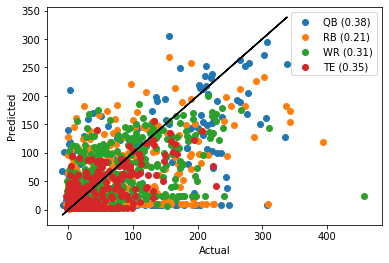

In [11]:
y_pred = {}
for pos in positions:
    m = neighbors.KNeighborsRegressor()
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 1985 out of 2000 | elapsed:   21.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   40.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.3min finished


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elaps

QB: {'metric': 'manhattan', 'n_neighbors': 32, 'weights': 'uniform'}
RB: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
WR: {'metric': 'manhattan', 'n_neighbors': 22, 'weights': 'distance'}
TE: {'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'distance'}


,QB,RB,WR,TE
MAE,52.600,37.500,34.800,23.200
RMSE,69.500,56.500,49.000,33.200
R^2,0.460,0.330,0.370,0.410


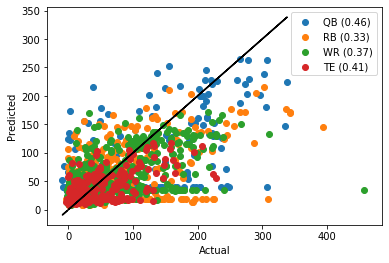

In [12]:
y_pred = {}
bestParams = {}
for pos in positions:
    params = {
        'weights':['distance','uniform'],
        'metric':['manhattan','euclidean'],
        'n_neighbors':[x for x in range(1,101)],
    }

    grid = GridSearchCV(
        neighbors.KNeighborsRegressor(),
        params,
        n_jobs = -1,
        verbose = 7,
        cv = 5
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_

    m = neighbors.KNeighborsRegressor(**grid.best_params_)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])

    #cvGrid(params)
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)